In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn import metrics
import myfm
from myfm.utils.benchmark_data import MovieLens100kDataManager
plt.style.use('ggplot')

In [10]:
data_manager = MovieLens100kDataManager()

# Data exploration 

## Old Movielens-100k

In [11]:
df_rating = data_manager.load_rating_all()
sparsity = 1 - len(df_rating) / (df_rating['movie_id'].unique().shape[0] * df_rating['user_id'].unique().shape[0])
print(f"sparsity: {sparsity:.4%}")
df_rating

sparsity: 93.6953%


,user_id,movie_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16
...,...,...,...,...
99995,880,476,3,1997-11-22 05:10:44
99996,716,204,5,1997-11-17 19:39:03
99997,276,1090,1,1997-09-20 22:49:55
99998,13,225,2,1997-12-17 22:52:36


Distribution of Ratings

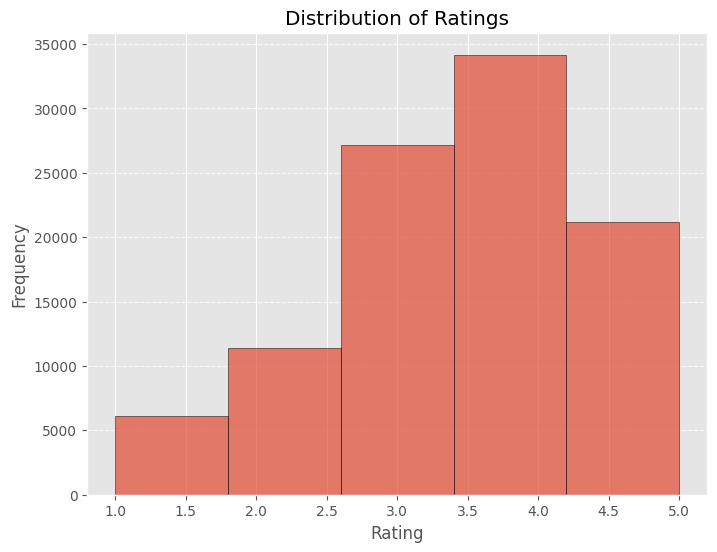

In [12]:
# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(df_rating['rating'], bins=5, edgecolor='black', alpha=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Distribution of Ratings per movie/user

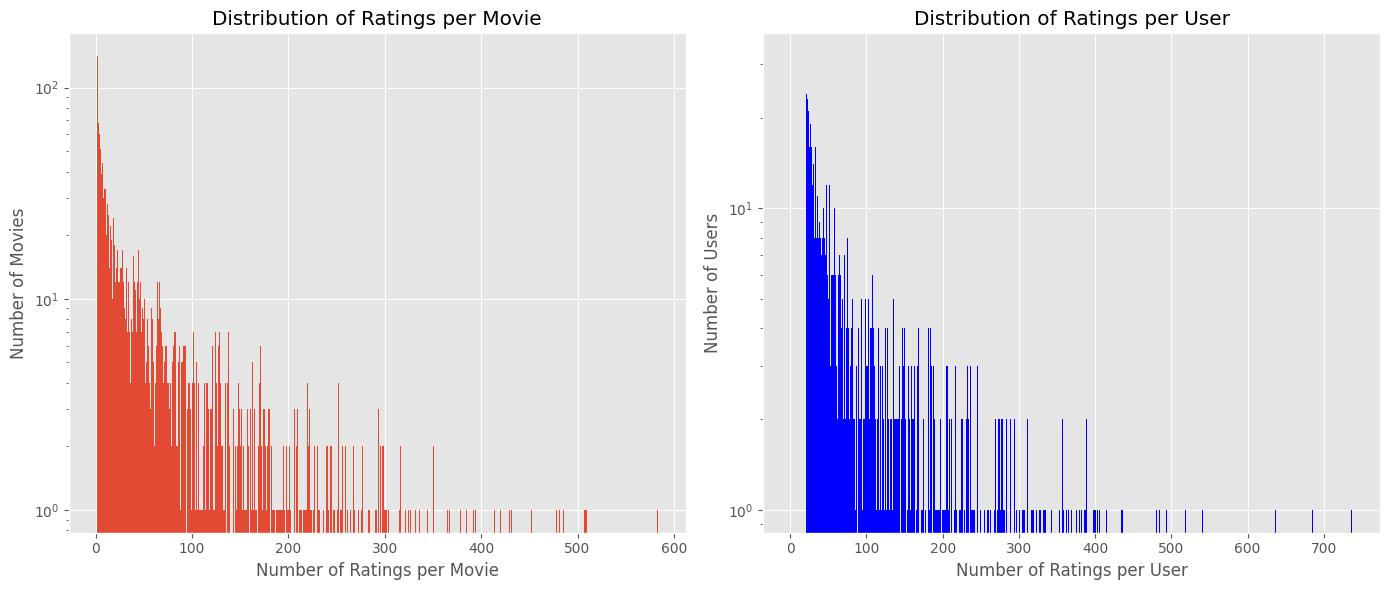

In [13]:
rating_count = df_rating['movie_id'].value_counts()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(rating_count, bins=range(1, rating_count.max() + 1), log=True)
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')
plt.title('Distribution of Ratings per Movie')
plt.grid(True)

user_rating_count = df_rating['user_id'].value_counts()
plt.subplot(1, 2, 2)
plt.hist(user_rating_count, bins=range(1, user_rating_count.max() + 1), log=True, color="blue")
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Ratings per User')
plt.grid(True)
plt.tight_layout()
plt.show()

### Additional metadata

In [14]:
df_user = data_manager.load_user_info()
df_user

,user_id,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [15]:
df_movie = data_manager.load_movie_info()
df_movie

,movie_id,title,release_date,unk,url,unknown,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genres
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,Animation|Children's|Comedy
1,2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,Action|Adventure|Thriller
2,3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Thriller
3,4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Action|Comedy|Drama
4,5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Crime|Drama|Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998-02-06,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Drama
1678,1679,B. Monkey (1998),1998-02-06,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,Romance|Thriller
1679,1680,Sliding Doors (1998),1998-01-01,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,Drama|Romance
1680,1681,You So Crazy (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Comedy


In [16]:
df_movie.drop(columns=['unk', 'url'], inplace=True)
df_movie

,movie_id,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genres
0,1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,Animation|Children's|Comedy
1,2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Action|Adventure|Thriller
2,3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Thriller
3,4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Action|Comedy|Drama
4,5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,Crime|Drama|Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998-02-06,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Drama
1678,1679,B. Monkey (1998),1998-02-06,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,Romance|Thriller
1679,1680,Sliding Doors (1998),1998-01-01,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,Drama|Romance
1680,1681,You So Crazy (1994),1994-01-01,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Comedy


# Recommender System Model

## Pure Collaborative Filtering (No extra metadata)

In [ ]:
from surprise import BaselineOnly, KNNBasic, KNNWithMeans, KNNBaseline, SVD, SVDpp, NMF, SlopeOne, CoClustering
from surprise.model_selection import cross_validate
from surprise import Dataset

# Load movielens-100k dataset
data = Dataset.load_builtin('ml-100k')

# List of algorithms to test
algorithms = [
    BaselineOnly(),
    KNNBasic(),
    KNNWithMeans(),
    KNNBaseline(),
    SVD(),
    SVDpp(),
    NMF(),
    SlopeOne(),
    CoClustering()
]

algo_names = [
    "BaselineOnly", "KNNBasic", "KNNWithMeans", "KNNBaseline",
    "SVD", "SVDpp", "NMF", "SlopeOne", "CoClustering",
]

# Dictionary to store results
results = {}

# Run cross-validation for each algorithm
for algo, name in zip(algorithms, algo_names):
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    results[name] = {
        "RMSE": np.mean(cv_results["test_rmse"]),
        "MAE": np.mean(cv_results["test_mae"])
    }

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating 

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn import metrics

FM_RANK = 10
df_train, df_test = data_manager.load_rating_predefined_split(fold=5)

FEATURE_COLUMNS = ['user_id', 'movie_id']
ohe = OneHotEncoder(handle_unknown='ignore')

X_train = ohe.fit_transform(df_train[FEATURE_COLUMNS])
X_test = ohe.transform(df_test[FEATURE_COLUMNS])
y_train = df_train.rating.values
y_test = df_test.rating.values

#fm = myfm.MyFMRegressor(rank=FM_RANK, random_seed=42)
#fm.fit(X_train, y_train, n_iter=200, n_kept_samples=200)

#prediction = fm.predict(X_test)
#rmse = ((y_test - prediction) ** 2).mean() ** .5
#mae = np.abs(y_test - prediction).mean()


fm_grouped = myfm.MyFMRegressor(
    rank=FM_RANK, random_seed=42,
)
fm_grouped.fit(
    X_train, y_train, n_iter=200, n_kept_samples=200,
    group_shapes=[len(group) for group in ohe.categories_]
)

prediction_grouped = fm_grouped.predict(X_test)
rmse = ((y_test - prediction_grouped) ** 2).mean() ** .5
mae = np.abs(y_test - prediction_grouped).mean()
print(f'rmse={rmse}, mae={mae}')
results["BFM"] = {
        "RMSE": rmse,
        "MAE": mae,
    }

  0%|          | 0/200 [00:00<?, ?it/s]

alpha = 1.64 w0 = 3.60 : 100%|██████████| 200/200 [00:02<00:00, 67.64it/s]


rmse=0.8966390690239949, mae=0.7081203078858516


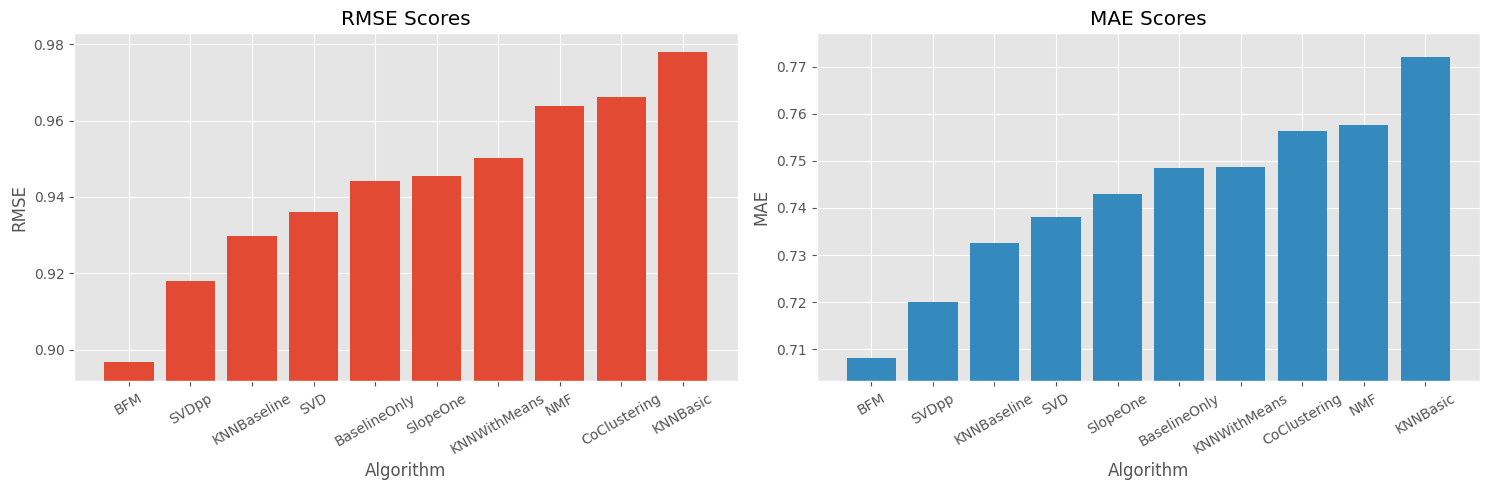

{'BaselineOnly': {'RMSE': 0.9440489140899201, 'MAE': 0.7485155769542691},
 'KNNBasic': {'RMSE': 0.9778733282145579, 'MAE': 0.772138252562263},
 'KNNWithMeans': {'RMSE': 0.9501949379026412, 'MAE': 0.7487168831441415},
 'KNNBaseline': {'RMSE': 0.9298104263239994, 'MAE': 0.7326281294017821},
 'SVD': {'RMSE': 0.9359887476817225, 'MAE': 0.7381299108828341},
 'SVDpp': {'RMSE': 0.9180096299003146, 'MAE': 0.720028295915244},
 'NMF': {'RMSE': 0.9637886229490829, 'MAE': 0.757689754931382},
 'SlopeOne': {'RMSE': 0.9454022100721187, 'MAE': 0.7430654581636447},
 'CoClustering': {'RMSE': 0.9661805259102424, 'MAE': 0.7563414379651864},
 'BFM': {'RMSE': 0.8966390690239949, 'MAE': 0.7081203078858516}}

In [26]:
algo_names = [
    "BaselineOnly", "KNNBasic", "KNNWithMeans", "KNNBaseline",
    "SVD", "SVDpp", "NMF", "SlopeOne", "CoClustering", "BFM"
]
rmse_scores = np.array([results[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results[name]["MAE"] for name in algo_names])

# Order algorithms independently
order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)

# Create ordered lists for each metric
algo_names_rmse = [algo_names[i] for i in order_rmse]
algo_names_mae = [algo_names[i] for i in order_mae]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]

# Create x-axis indices
x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot RMSE on the left, ordered by RMSE
ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("RMSE Scores")
ax1.set_xlabel("Algorithm")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=30)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

# Plot MAE on the right, ordered by MAE
ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("MAE Scores")
ax2.set_xlabel("Algorithm")
ax2.set_ylabel("MAE")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=30)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

plt.tight_layout()
plt.show()
results